In [1]:
import pandas as pd
import numpy as np

# Load the .ori orientation file
ori_path = "DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)

ori_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_34876\4138381853.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


,prefix,timestamp,x_lat,x_lon,z_lat,z_lon,altitude_km,Earth_lat,Earth_lon
0,OG,1.835487e+09,59.274529,22.415898,-30.725471,22.415898,530.222097,-0.000190,27.047042
1,OG,1.835487e+09,58.504010,22.732337,-31.495990,22.732337,530.219997,-0.000184,27.927215
2,OG,1.835487e+09,57.732736,23.048787,-32.267264,23.048787,530.216960,-0.000177,28.807377
3,OG,1.835487e+09,56.960731,23.365378,-33.039269,23.365378,530.212986,-0.000171,29.687529
4,OG,1.835487e+09,56.188017,23.682244,-33.811983,23.682244,530.208077,-0.000165,30.567670


In [2]:
# Drop the non-informative 'prefix' column (always 'OG')
ori_df = ori_df.drop(columns=["prefix"])

# Convert timestamps to datetime format
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Keep only the first day of data
first_day = ori_df["timestamp"].iloc[0].normalize()
ori_df = ori_df[ori_df["timestamp"] < first_day + pd.Timedelta(days=1)]

ori_df.head()

,timestamp,x_lat,x_lon,z_lat,z_lon,altitude_km,Earth_lat,Earth_lon
0,2028-03-01 01:35:00,59.274529,22.415898,-30.725471,22.415898,530.222097,-0.000190,27.047042
1,2028-03-01 01:35:15,58.504010,22.732337,-31.495990,22.732337,530.219997,-0.000184,27.927215
2,2028-03-01 01:35:30,57.732736,23.048787,-32.267264,23.048787,530.216960,-0.000177,28.807377
3,2028-03-01 01:35:45,56.960731,23.365378,-33.039269,23.365378,530.212986,-0.000171,29.687529
4,2028-03-01 01:36:00,56.188017,23.682244,-33.811983,23.682244,530.208077,-0.000165,30.567670


In [3]:
# Load the detector data and timestamps
time_array = np.load("time_array.npy")
rates = np.load("total_rates.npy")

# Remove the extra dimension from rates array
rates = np.squeeze(rates)

# Convert time_array to datetime
time_series = pd.to_datetime(time_array, unit='s')

# Create DataFrame with detector rates and timestamp
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series  # <-- This was missing

# Filter from 13:00 onward
cutoff_time = pd.Timestamp("2028-03-01 13:00:00")
clean_rates_df = rates_df[rates_df["timestamp"] >= cutoff_time].copy()

# Check columns
print(clean_rates_df.columns)

Index(['detector_1', 'detector_2', 'detector_3', 'detector_4', 'detector_5',
       'detector_6', 'timestamp'],
      dtype='object')


In [4]:
# Check time ranges
print("Orientation start:", ori_df['timestamp'].min())
print("Orientation end:", ori_df['timestamp'].max())

print("Rates start:", rates_df['timestamp'].min())
print("Rates end:", rates_df['timestamp'].max())

# Check if time deltas match 15s binning
pd.Series(rates_df['timestamp'].diff().dropna().unique())

Orientation start: 2028-03-01 01:35:00
Orientation end: 2028-03-01 23:59:45
Rates start: 2028-03-01 01:35:00.002068042
Rates end: 2028-03-02 01:34:45.002068042


0               0 days 00:00:15
1   -1 days +09:17:41.727963925
dtype: timedelta64[ns]

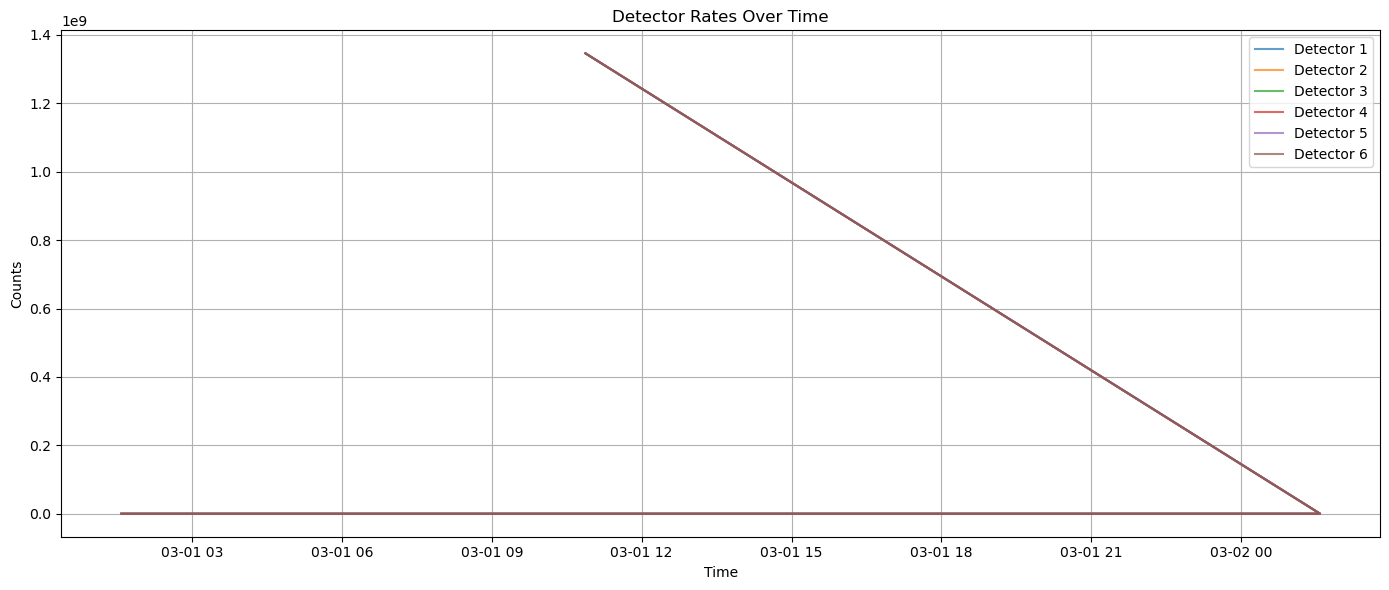

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i in range(1, 7):
    plt.plot(rates_df['timestamp'], rates_df[f'detector_{i}'], label=f'Detector {i}', alpha=0.7)

plt.title("Detector Rates Over Time")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
rates_df.describe()
# the max might be too big. lets try to crop out some outliers

,detector_1,detector_2,detector_3,detector_4,detector_5,detector_6,timestamp
count,5.761000e+03,5.761000e+03,5.761000e+03,5.761000e+03,5.761000e+03,5.761000e+03,5761
mean,2.347918e+05,2.347952e+05,2.346366e+05,2.346369e+05,2.345803e+05,2.345806e+05,2028-03-01 13:34:50.810387200
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2028-03-01 01:35:00.002068042
25%,1.229867e+03,1.242267e+03,1.023533e+03,1.069400e+03,9.685333e+02,1.008067e+03,2028-03-01 07:35:00.002067968
50%,1.368200e+03,1.363133e+03,1.193733e+03,1.162600e+03,1.111133e+03,1.107133e+03,2028-03-01 13:34:45.002067968
75%,1.441867e+03,1.441267e+03,1.257000e+03,1.240600e+03,1.191067e+03,1.164867e+03,2028-03-01 19:34:45.002067968
max,1.346039e+09,1.346040e+09,1.346040e+09,1.346041e+09,1.346041e+09,1.346041e+09,2028-03-02 01:34:45.002068042
std,1.773406e+07,1.773408e+07,1.773408e+07,1.773409e+07,1.773410e+07,1.773410e+07,NaN


In [7]:
# Cutoff time to exclude early invalid data
# as mentioned, we consider data only after 1pm
# cause - invalid warmup data.
start_time = pd.Timestamp("2028-03-01 13:00:00")
end_time = pd.Timestamp("2028-03-02 0:00:00")

clean_rates_df = rates_df[
    (rates_df["timestamp"] >= start_time) & (rates_df["timestamp"] < end_time)
].copy()



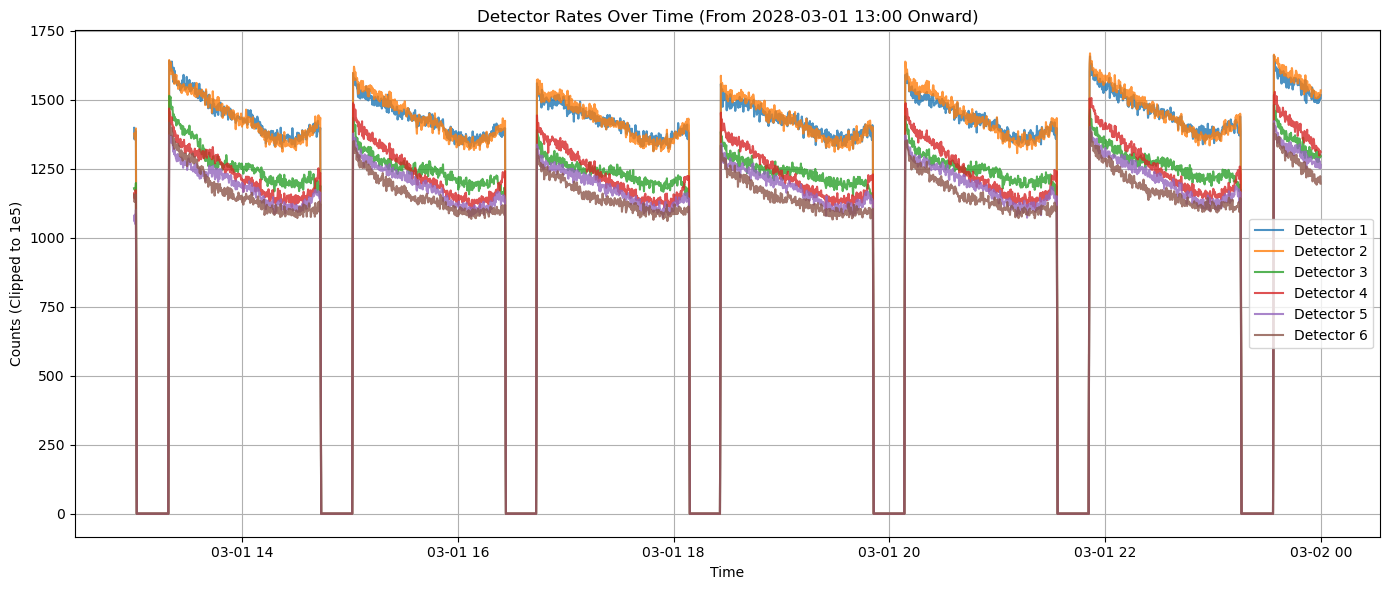

In [12]:
#replot
# Clip for visualization (removes outlier influence)
plt.figure(figsize=(14, 6))
for i in range(1, 7):
    clipped = clean_rates_df[f'detector_{i}'].clip(upper=1e5)
    plt.plot(clean_rates_df['timestamp'], clipped, label=f'Detector {i}', alpha=0.8)

plt.title("Detector Rates Over Time (From 2028-03-01 13:00 Onward)")
plt.xlabel("Time")
plt.ylabel("Counts (Clipped to 1e5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
#function to plot the detector signal. parameter - the number of detectors we want to plot
def plot_detectors(detect_number):

    if detect_number > 1:
        fig, axs = plt.subplots(nrows=detect_number, ncols=1, figsize=(14, 12), sharex=True)
    
        for i in range(detect_number):
            ax = axs[i]
            clipped = clean_rates_df[f'detector_{i+1}']
            ax.plot(clean_rates_df['timestamp'], clipped, color='C'+str(i), alpha=0.8)
            ax.set_ylabel(f'Detector {i+1}')
            ax.grid(True)
        
        axs[0].set_title("Clipped Detector Rates (From 2028-03-01 13:00 Onward)")
        axs[-1].set_xlabel("Time")
        
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(14, 5))
        clipped = clean_rates_df[f'detector_{detect_number}'].clip(upper=1e5)
        plt.plot(clean_rates_df['timestamp'], clipped, color=f'C{detect_number-1}', alpha=0.8)
        plt.ylabel(f'Detector {detect_number}')  # ✅ FIXED
        plt.title("Clipped Detector Rates (From 2028-03-01 13:00 Onward)")
        plt.xlabel("Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        


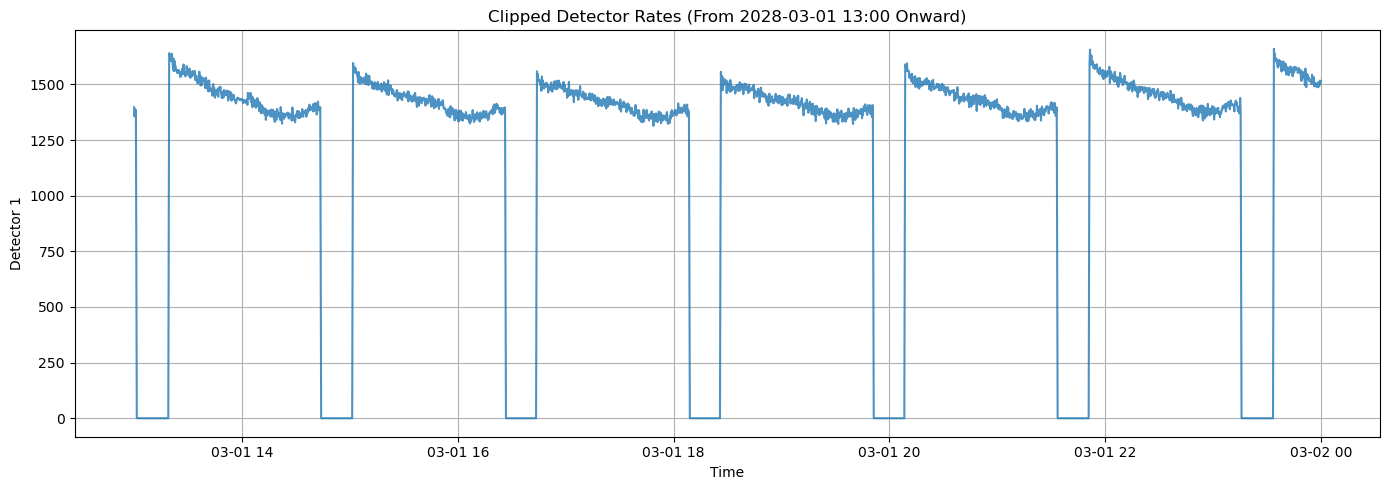

In [32]:
plot_detectors(1)

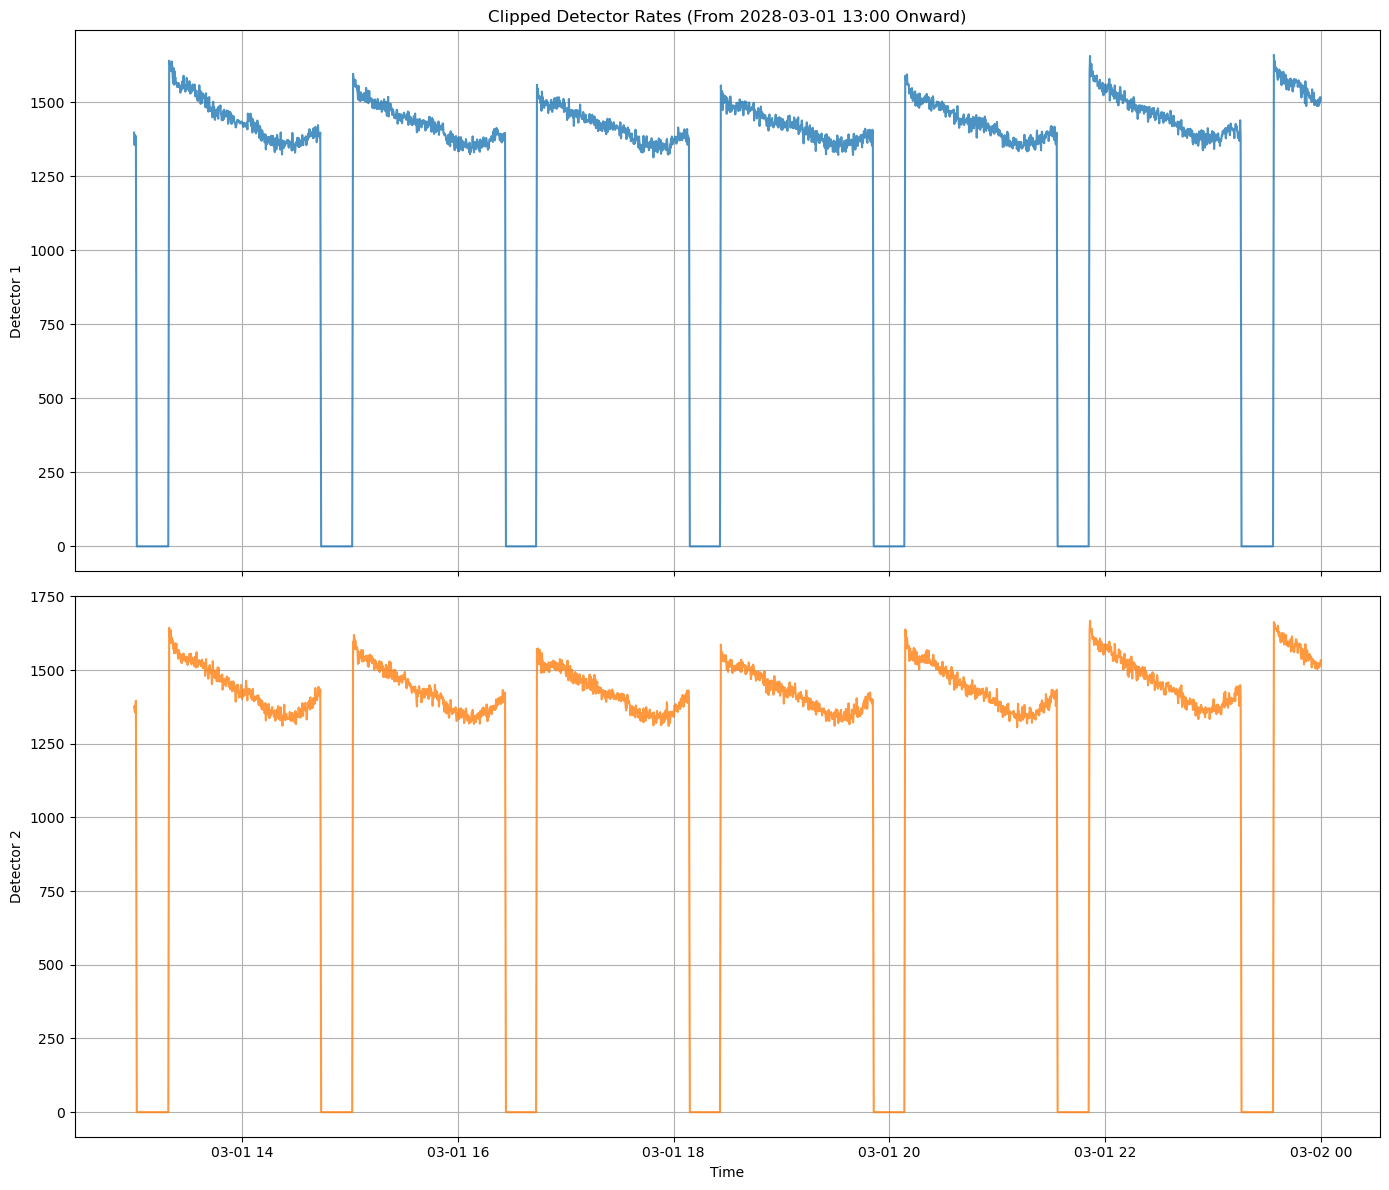

In [33]:
plot_detectors(2)